Using Gaus4 wavelet function

Saved: D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\segmented_wall_morl.png
Stones detected: 12


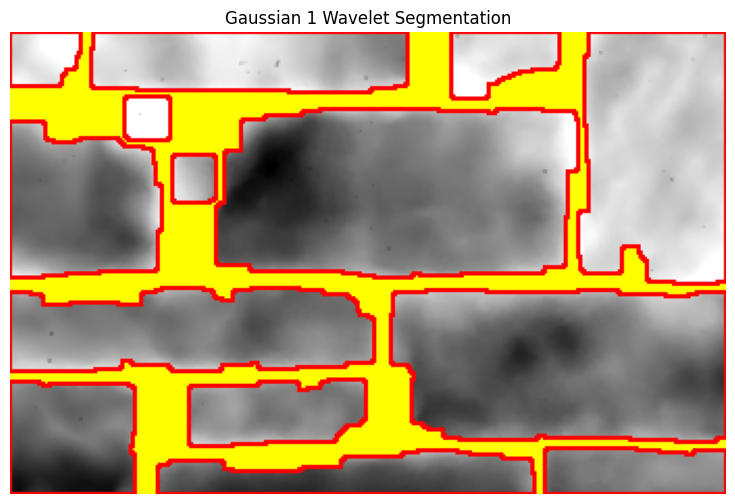

In [71]:
import numpy as np
import pywt
from skimage import io, morphology, filters, measure, img_as_ubyte
import matplotlib.pyplot as plt
import os

# Load and normalize depth map
depth_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\image_copy.png"
depth = io.imread(depth_path, as_gray=True).astype(float)
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = filters.median(depth, morphology.disk(1))

scale = 2
pad = scale * 2
rows, cols = depth.shape
scales = [scale]
wavelet = 'gaus4'

# CWT row-wise
vertical_response = np.zeros_like(depth)
for i in range(rows):
    padded = np.pad(depth[i, :], pad, mode='symmetric')
    coeffs, _ = pywt.cwt(padded, scales, wavelet)
    vertical_response[i, :] = coeffs[0][pad:-pad]

# CWT column-wise
horizontal_response = np.zeros_like(depth)
for j in range(cols):
    padded = np.pad(depth[:, j], pad, mode='symmetric')
    coeffs, _ = pywt.cwt(padded, scales, wavelet)
    horizontal_response[:, j] = coeffs[0][pad:-pad]

# Combine responses
vertical_response[vertical_response < 0] = 0
horizontal_response[horizontal_response < 0] = 0
cwt_response = np.maximum(vertical_response, horizontal_response)

# Threshold and cleanup
threshold = np.percentile(cwt_response, 82)
mortar_mask = cwt_response >= threshold
mortar_mask = morphology.remove_small_objects(mortar_mask, min_size=30)
mortar_mask = morphology.binary_closing(mortar_mask, morphology.square(3))
mortar_mask = morphology.binary_closing(mortar_mask, morphology.rectangle(1, 20))
mortar_mask = morphology.binary_closing(mortar_mask, morphology.rectangle(20, 1))
# mortar_mask = morphology.binary_dilation(mortar_mask, morphology.disk(1))

mortar_mask = morphology.binary_closing(mortar_mask, morphology.rectangle(1, 15))  # preserve horizontal lines
mortar_mask = morphology.binary_closing(mortar_mask, morphology.rectangle(15, 1))  # preserve vertical lines
mortar_mask = morphology.remove_small_objects(mortar_mask, min_size=40)
mortar_mask = morphology.binary_erosion(mortar_mask, morphology.disk(1))  # shrink back over-detected areas


# Stone mask and outline
stone_mask = ~mortar_mask
eroded = morphology.binary_erosion(stone_mask, morphology.square(5))
stone_outline = stone_mask & ~eroded
stone_outline[0, :]  |= stone_mask[0, :]
stone_outline[-1, :] |= stone_mask[-1, :]
stone_outline[:, 0]  |= stone_mask[:, 0]
stone_outline[:, -1] |= stone_mask[:, -1]

# Overlay and save
output = np.dstack([depth, depth, depth])
output[mortar_mask] = [1, 1, 0]
output[stone_outline] = [1, 0, 0]
save_path = os.path.join(os.path.dirname(depth_path), "segmented_wall_morl.png")
io.imsave(save_path, img_as_ubyte(output))
print("Saved:", save_path)

# Count stones
labelled = measure.label(stone_mask)
print("Stones detected:", labelled.max())

# Display
plt.figure(figsize=(10, 6))
plt.imshow(output)
plt.title("Gaussian 1 Wavelet Segmentation")
plt.axis("off")
plt.show()



Extraction of Segmentation Prediction Mask

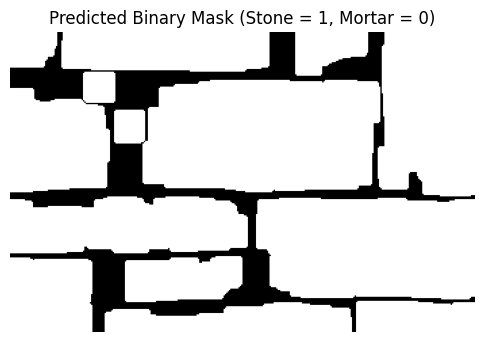

In [73]:
# --- Extract predicted stone mask from CWT-based segmentation ---

# Use the binary stone mask directly
# It's already a 2D boolean array where:
#   - stone = True
#   - mortar = False

predicted_mask = stone_mask.astype(np.uint8)  # Convert to 0 and 1 (stone = 1, mortar = 0)

# Optional: Visualize the predicted binary mask
plt.figure(figsize=(6, 6))
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Binary Mask (Stone = 1, Mortar = 0)")
plt.axis("off")
plt.show()


Computation of Evaluation Metrics

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def evaluate_segmentation(pred_mask, gt_mask, verbose=True):
    """
    Evaluate binary segmentation performance.

    Parameters:
        pred_mask (np.ndarray): Predicted binary mask (0 = mortar, 1 = stone)
        gt_mask (np.ndarray): Ground truth binary mask (0 = mortar, 1 = stone)
        verbose (bool): Whether to print results

    Returns:
        dict: Dictionary of evaluation metrics
    """

    # Check dimensions match
    assert pred_mask.shape == gt_mask.shape, "Predicted and ground truth masks must have the same shape."

    # Ensure binary
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    # Flatten masks to 1D
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    # Confusion matrix
    cm = confusion_matrix(gt_flat, pred_flat, labels=[1, 0])  # [stone, mortar]
    TP = cm[0, 0]  # True positive: stone correctly predicted
    FN = cm[0, 1]  # False negative: stone missed
    FP = cm[1, 0]  # False positive: mortar predicted as stone
    TN = cm[1, 1]  # True negative: mortar correctly predicted

    # Metric scores
    accuracy  = accuracy_score(gt_flat, pred_flat)
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall    = recall_score(gt_flat, pred_flat, zero_division=0)
    f1        = f1_score(gt_flat, pred_flat, zero_division=0)
    iou       = jaccard_score(gt_flat, pred_flat, zero_division=0)

    results = {
        'True Positive (stone)': TP,
        'False Negative (missed stone)': FN,
        'False Positive (mortar as stone)': FP,
        'True Negative (mortar)': TN,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'IoU (Jaccard)': iou
    }

    if verbose:
        print("\nSegmentation Evaluation Metrics:")
        for k, v in results.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return results


In [75]:
from PIL import Image
import numpy as np

# === Load Ground Truth Mask (LabelMe-based binary mask) ===
gt_mask_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\stones_labels_JSON_binary_mask.png"
gt_mask = np.array(Image.open(gt_mask_path).convert('L'))  # Load as grayscale
gt_mask = (gt_mask > 127).astype(np.uint8)  # Convert to binary (1 = stone, 0 = mortar)

# === Predicted Mask from CWT segmentation ===
predicted_mask = stone_mask.astype(np.uint8)  # 1 = stone, 0 = mortar

# === Evaluate ===
results = evaluate_segmentation(predicted_mask, gt_mask)




Segmentation Evaluation Metrics:
True Positive (stone): 61366
False Negative (missed stone): 8217
False Positive (mortar as stone): 1707
True Negative (mortar): 5078
Accuracy: 0.8701
Precision: 0.9729
Recall: 0.8819
F1 Score: 0.9252
IoU (Jaccard): 0.8608


Visualization of Confusion Map

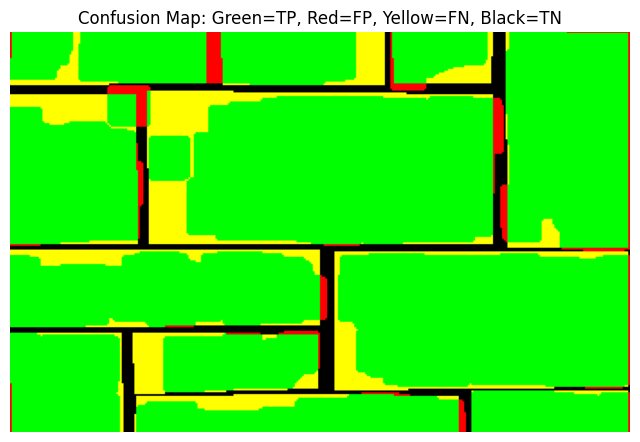

In [76]:
import matplotlib.pyplot as plt

def visualize_confusion(pred_mask, gt_mask):
    conf_map = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)

    conf_map[(gt_mask == 1) & (pred_mask == 1)] = [0, 255, 0]     # TP = green
    conf_map[(gt_mask == 0) & (pred_mask == 0)] = [0, 0, 0]       # TN = black
    conf_map[(gt_mask == 0) & (pred_mask == 1)] = [255, 0, 0]     # FP = red
    conf_map[(gt_mask == 1) & (pred_mask == 0)] = [255, 255, 0]   # FN = yellow

    plt.figure(figsize=(8, 8))
    plt.imshow(conf_map)
    plt.title("Confusion Map: Green=TP, Red=FP, Yellow=FN, Black=TN")
    plt.axis("off")
    plt.show()

# === Run visualization ===
visualize_confusion(predicted_mask, gt_mask)


Computation of TPLF

In [79]:

# Compute TPLF (True Positive Localization Fraction)
def compute_tplf(tp, fn):
    if (tp + fn) == 0:
        return 0.0
    return tp / (tp + fn)

# Example usage (replace these values with your actual results)
TP = 61366  # True Positives
FN = 8217   # False Negatives
TPLF = compute_tplf(TP, FN)
print(f"TPLF = {TPLF:.4f}")


TPLF = 0.8819


Computation of FPR

In [80]:

# Compute FPR (False Positive Rate)
def compute_fpr(fp, tp):
    if (tp + fp) == 0:
        return 0.0
    return fp / (tp + fp)

# Example usage (replace these values with your actual results)
FP = 1707   # False Positives
TP = 61366  # True Positives
FPR = compute_fpr(FP, TP)
print(f"FPR = {FPR:.4f}")


FPR = 0.0271
